# Chapter 3. 평가

성능 평가 지표(Evaluation Metric)은 회귀냐 분류나에 따라 다릅니다.
- 회귀의 경우 대부분 실제값과 예측값의 오차 평균값에 기반합니다.
- 분류의 성능 평가 지표
    - 정확도(Accuracy)
    - 오차행렬(Confusion Matrix)
    - 정밀도(Precision)
    - 재현율(Recall)
    - F1 Score
    - ROC AUC

분류는 이진 분류와 멀티 분류로 나뉠 수 있는데, 특히 이진 분류에서 더욱 중요하게 강조하는 지표입니다.

## 1. 정확도(Accuracy)
### $정확도(Accuracy) = \frac{정답}{전체 예측}$
정확도는 ML 모델의 성능을 왜곡할 수 있습니다.

In [1]:
# 정확도의 왜곡 확인
# BaseEstimator를 상속받아 Customized Estimator 개발 가능
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator

from practice.transform import transform_features

class MyDummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    # 단순히 Sex가 1인 경우 0, 0이면 1로 예측
    def predict(self, x):
        pred = np.zeros((x.shape[0], 1))
        for i in range(x.shape[0]):
            if x['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        
        return pred
    
titanic_df = pd.read_csv('./dataset/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
x_titanic_df = titanic_df.drop('Survived', axis=1)  # Survived 삭제
x_titanic_df = transform_features(x_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(x_titanic_df, y_titanic_df, test_size=0.2)

# DummyClass로 학습/예측/평가
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

myprediction = myclf.predict(X_test)
print("Dummy Classifier 정확도: {0:.4f}".format(accuracy_score(y_test, myprediction)))

Dummy Classifier 정확도: 0.7430


아무것도 학습시키지 않아도 74%의 정확도가 나오는 것을 확인할 수 있습니다.
이처럼 정확도를 평가 지표로 사용할 때는 매우 신중해야 합니다. 특히 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아닙니다.

## 2. 오차 행렬

오차행렬(confusion matrix, 혼동행렬)은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused)있는지도 함께 보여주는 지표입니다. 즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표입니다.

- TN: 맞췄다(True), Negative(0)으로 예측해서
- TP: 맞췄다(True), Positive(1)로 예측해서
- FN: 틀렸다(False), Negative(0)으로 예측해서
- FP: 틀렸다(False), Positive(1)로 예측해서

In [4]:
from sklearn.metrics import confusion_matrix

# numpy 형태로 반환
confusion = confusion_matrix(y_test, myprediction)
print(confusion)

print("TN: ", confusion[0][0])
print("FP: ", confusion[0][1])
print("FN: ", confusion[1][0])
print("TP: ", confusion[1][1])

[[79 18]
 [28 54]]
TN:  79
FP:  18
FN:  28
TP:  54


- 정확도 = (TN + TP) / (TN + FP + FN + TP)

불균형한 레이블 클래스를 가지는 이진 분류 모델은 매우 적은 수의 결괏값에 Positive를 설정해 1값을, 그렇지 않은 경우는 Negative 0 값을 부여하는 경우가 많습니다. (ex: 사기인 경우 1, 정상이면 0)

불균형한 레이블을 정확도로 평가한다면, 모두 Negative로 예측하는 경우에도 **정확도가 매우 높게 나타나는** 수치적인 판단 오류를 나타냅니다.

## 3. 정밀도와 재현율
**정밀도**는 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터 비율을 뜻합니다.
- 정밀도 = TP / (FP + TP)

Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 양성 예측도로 불립니다.

**재현율**은 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율을 뜻합니다.
- 재현율 = TP / (FN + TP)

**재현율이 중요 지표인 경우는 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우입니다.**

예를 들어서 암에 걸린 환자를 정상으로 판단하게 된 경우, 치명적인 실수가 발생하게 됩니다. 정상인 환자를 암 환자라고 판단하면 정밀 검사를 하면 되는 해프닝으로 마무리 됩니다.

정밀도가 더 중요한 지표는 스팸메일 여부를 판단하는 모델입니다. 일반적인 메일을 스팸메일로 구분하게 된다면 업무상 차질이 생깁니다. 스팸메일을 구분하지 못하면 손으로 직접 옮기면 되는 부분입니다.

- 재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
- 정밀도가 상대적으로 더 중요한 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우

재현율과 정밀도는 TP를 올리는데 동일하지만, 재현율은 FN(실제 Positive, 예측 Negative)를 낮추는 데, 정밀도는 FP(실제 Negative, 예측 Positive)를 낮추는 데 초점을 둡니다.

즉 FN을 낮추는 것을 최대한 많은 예측을, FP를 낮추는 것은 최대한 정확한 예측을 할 때 중요한 지표라고 생각하면 좋을 것 같습니다.

가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것입니다.

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율

    print("오차 행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}".format(accuracy, precision, recall))

In [7]:
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv("./dataset/titanic/train.csv")
y_titanic_df = titanic_df['Survived']
x_titanic_df = titanic_df.drop('Survived', axis=1)  # Survived 삭제
x_titanic_df = transform_features(x_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(x_titanic_df, y_titanic_df, test_size=0.2)

lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)    # 학습
pred = lr_clf.predict(X_test)   # 예측

get_clf_eval(y_test, pred)  # 평가

오차 행렬
[[86 20]
 [17 56]]
정확도: 0.7933, 정밀도: 0.7368, 재현율: 0.7671


정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽습니다. 이를 정밀도/재현율의 트레이드오프(Trade-off)라고 부릅니다.

In [8]:
# predict_proba(): 개별 데이터별로 예측 확률을 반환하는 메서드
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba() 결과 shape: {0}".format(pred_proba.shape))
print(pred_proba[:3])

# 뒤에 레이블 합치기
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1) 
print("두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n", pred_proba_result[:3])

pred_proba() 결과 shape: (179, 2)
[[0.68425063 0.31574937]
 [0.41449197 0.58550803]
 [0.83237335 0.16762665]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.68425063 0.31574937 0.        ]
 [0.41449197 0.58550803 1.        ]
 [0.83237335 0.16762665 0.        ]]


In [9]:
# Binarizer 클래스를 이용하면 입력된 ndarray의 값을 지정된 threshold보다 
# 같거나 작으면 0값으로, 크면 1값으로 변환한다
from sklearn.preprocessing import Binarizer
custom_threshold = 0.5

# predict_proba() 변환값의 두 번째 칼럼, 즉 positive 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

# custom_threshold를 이용하여 값 변환
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict) # 같은 값을 얻는 것을 볼 수 있다.

오차 행렬
[[86 20]
 [17 56]]
정확도: 0.7933, 정밀도: 0.7368, 재현율: 0.7671


In [10]:
custom_threshold = 0.4 # threshold 값을 0.4로 변환

# predict_proba() 변환값의 두 번째 칼럼, 즉 positive 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

# custom_threshold를 이용하여 값 변환
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[81 25]
 [13 60]]
정확도: 0.7877, 정밀도: 0.7059, 재현율: 0.8219


재현율 값이 올라가고 정밀도가 떨어졌습니다. 임계값을 낮출수록 True 값이 많아지게 됩니다.

Positive 예측값이 많아지면 상대적으로 재현율 값이 높아집니다. 양성 예측을 많이 하다 보니 실제 양성을 음성으로 예측하는 횟수가 상대적으로 줄어들기 때문입니다.

In [13]:
threshold = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, threshold):
    for custom_threshold in threshold:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임계값: ", custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print()

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), threshold)

임계값:  0.4
오차 행렬
[[81 25]
 [13 60]]
정확도: 0.7877, 정밀도: 0.7059, 재현율: 0.8219

임계값:  0.45
오차 행렬
[[84 22]
 [14 59]]
정확도: 0.7989, 정밀도: 0.7284, 재현율: 0.8082

임계값:  0.5
오차 행렬
[[86 20]
 [17 56]]
정확도: 0.7933, 정밀도: 0.7368, 재현율: 0.7671

임계값:  0.55
오차 행렬
[[92 14]
 [19 54]]
정확도: 0.8156, 정밀도: 0.7941, 재현율: 0.7397

임계값:  0.6
오차 행렬
[[97  9]
 [22 51]]
정확도: 0.8268, 정밀도: 0.8500, 재현율: 0.6986



이와 비슷한 API는 precision_recall_curve() 입니다.
- 입력 파라미터
    - y_true: 실제 클래스값 배열
    - probas_pred: Positive 칼럼의 예측 확률 배열
- 반환 값
    - 정밀도: 임계값별 정밀도 값을 배열로 반환
    - 재현율: 임계값별 재현율 값을 배열로 반환

In [16]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임곗값 배열의 shape: ", thresholds.shape)

thr_index = np.arange(0, thresholds.shape[0], 15) # 15씩 증가
print("추출한 index 10개: ", thr_index)
print("추출한 threshold 값: ", thresholds[thr_index])

print("임계값별 정밀도: ", np.round(precision[thr_index], 3))
print("임계값별 재현율: ", np.round(recall[thr_index], 3))

반환된 분류 결정 임곗값 배열의 shape:  (173,)
추출한 index 10개:  [  0  15  30  45  60  75  90 105 120 135 150 165]
추출한 threshold 값:  [0.0394482  0.08627341 0.11214284 0.13540628 0.16140591 0.2501779
 0.42424275 0.55147642 0.62888424 0.77622988 0.87787452 0.93968754]
임계값별 정밀도:  [0.408 0.445 0.486 0.538 0.591 0.657 0.714 0.794 0.906 0.947 0.957 1.   ]
임계값별 재현율:  [1.    1.    0.973 0.959 0.932 0.89  0.822 0.74  0.658 0.493 0.301 0.11 ]


임곗값이 증가할수록 정밀도가 증가하지만 재현율 값은 낮아짐을 알 수 있습니다.

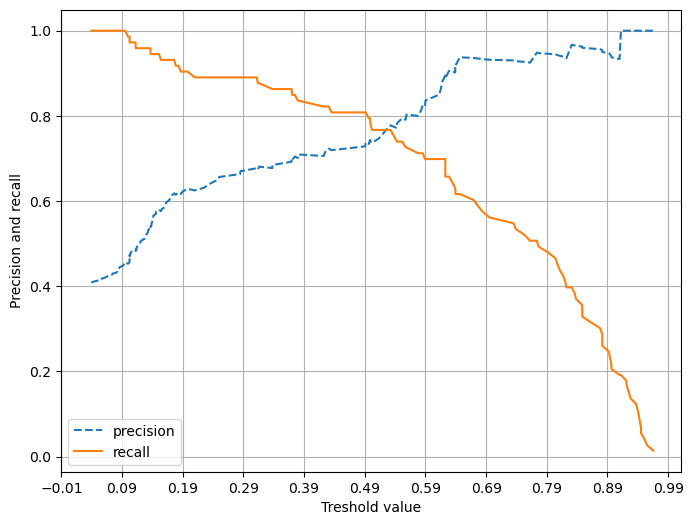

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as xticks

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold에 따른 정밀도, 재현율 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # x축: threshold
    # y축: 정밀도, 재현율
    # 정밀도는 점선으로 표현
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')

    # x축의 scale을 0.1 단위로 설정
    start, end = plt.xlim() 
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel("Treshold value")
    plt.ylabel("Precision and recall")
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 합니다. 그렇지 않고 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용해서는 안 됩니다.

- 정밀도가 100%가 되는 방법: 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측합니다.
- 재현율이 100%가 되는 방법: 모든 경우를 Positive로 예측합니다.

이처럼 정밀도와 재현율 성능 수치도 어느 한쪽만 참조하면 극단적인 수치 조작이 가능합니다.

## 4. F1 Score
F1 score는 정밀도와 재현율을 결합한 지표입니다. 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 갖습니다.

### $F1 = \frac{2}{\frac{1}{recall} + \frac{1}{precision}} = 2 * \frac{precision * recall}{precision + recall}$

In [23]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print("F1 score: {0:.4f}".format(f1))

F1 score: 0.7517


In [24]:
# F1 score 추가

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율

    f1 = f1_score(y_test, pred) # F1 score

    print("오차 행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}".format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값:  0.4
오차 행렬
[[81 25]
 [13 60]]
정확도: 0.7877, 정밀도: 0.7059, 재현율: 0.8219, F1: 0.7595

임계값:  0.45
오차 행렬
[[84 22]
 [14 59]]
정확도: 0.7989, 정밀도: 0.7284, 재현율: 0.8082, F1: 0.7662

임계값:  0.5
오차 행렬
[[86 20]
 [17 56]]
정확도: 0.7933, 정밀도: 0.7368, 재현율: 0.7671, F1: 0.7517

임계값:  0.55
오차 행렬
[[92 14]
 [19 54]]
정확도: 0.8156, 정밀도: 0.7941, 재현율: 0.7397, F1: 0.7660

임계값:  0.6
오차 행렬
[[97  9]
 [22 51]]
정확도: 0.8268, 정밀도: 0.8500, 재현율: 0.6986, F1: 0.7669



## 5. ROC 곡선과 AUC
ROC와 AUC는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표입니다.

ROC 곡선(Receiver Operation Characteristic Curve, 수신자 판단 곡선): FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)가 어떻게 변하는지를 나타내는 곡선입니다.
- TPR = Recall 즉, 재현율입니다. '민감도'라고도 불립니다. (질병이 있는 사람은 질병이 있는 것으로 판정)
- TNR은 특이성(specificity)이라고도 불리며 민감도에 대응하는 지표입니다. 실제값 Negative가 정확히 예측돼야 하는 수준을 나타냅니다. (질병이 없는 사람은 질병이 없는 것으로 판정)

### $TNR = \frac{TN}{(FP+TN)}$
### $FPR = \frac{FP}{(FP+TN)} = 1 - TNR = 1 - 특이성$

ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것이며, 멀어질수록 성능이 뛰어난 것입니다.

분류 결정 임곗값을 변경하면 FPR도 변경할 수 있습니다. 
분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준이기 때문에 FPR을 0으로 만들려면 임곗값을 1로 지정하면 됩니다. 반대로 TN을 0으로 만들면 FPR을 1로 만들 수 있습니다.

사이킷런은 roc_curve() API를 제공합니다.
- 입력 파라미터
    - y_true: 실제 클래스 값 array (array shape = [데이터 건수])
    - y_score: predict_proba()의 반환 값 array에서 Positive column이 보통 사용 됨. (array shape = [n_samples])

- 반환 값
    - fpr: fpr 값을 array로 반환
    - tpr: tpr 값을 array로 반환
    - thresholds: threshold 값 array

In [26]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]  # 레이블 값이 1일때의 예측 확률을 추출

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# thresholds[0]은 max(예측확률)+1로 임의 설정 됨. 이를 제외하기 위해서는 1부터 시작
print("thresholds[0]: ", thresholds[0])


thr_index = np.arange(1, thresholds.shape[0], 5)
print("thresholds 임계값: ", thr_index)
print("index에 따른 임계값: ", thresholds[thr_index])

print("FPR: ", np.round(fprs[thr_index], 3))
print("TPR: ", np.round(tprs[thr_index], 3))

thresholds[0]:  1.965501786053236
thresholds 임계값:  [ 1  6 11 16 21 26 31 36 41 46 51 56 61]
index에 따른 임계값:  [0.96550179 0.77367881 0.63903702 0.58550803 0.54279379 0.49147586
 0.3798608  0.31574937 0.21000019 0.17603963 0.11597855 0.10236839
 0.0394482 ]
FPR:  [0.    0.019 0.047 0.104 0.151 0.198 0.245 0.283 0.368 0.396 0.67  0.755
 1.   ]
TPR:  [0.014 0.507 0.63  0.712 0.74  0.808 0.836 0.877 0.89  0.932 0.959 0.986
 1.   ]


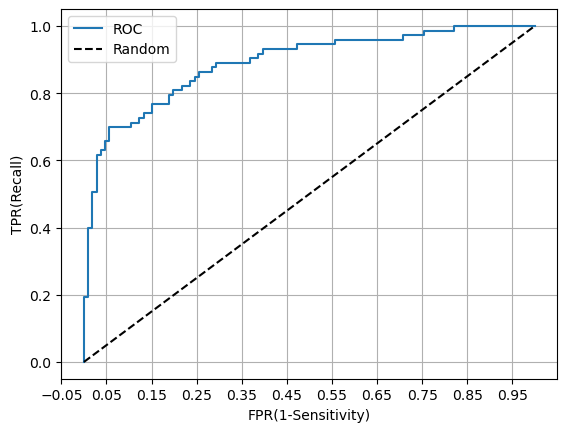

In [28]:
import matplotlib.ticker as ticks

def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)

    # ROC 곡선 그리기
    plt.plot(fprs, tprs, label = "ROC")

    # 가운데 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label = "Random")

    # x축의 scale을 0.1 단위로 설정
    start, end = plt.xlim() 
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel("FPR(1-Sensitivity)")
    plt.ylabel("TPR(Recall)")
    plt.legend()
    plt.grid()
    plt.show()

roc_curve_plot(y_test, pred_proba[:, 1])

AUC(Area Under Curve) 값은 ROC 곡선의 밑 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치입니다.
AUC가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건입니다. 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이 되어 면적이 1에 가까워지는 좋은 ROC AUC 성능 수치를 얻게 됩니다.

In [29]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8898
